# Data Science Work Sample Assessment

### Using Open Street Maps to find all food trucks in Indianapolis, IN

In [83]:
#importing packages for gathering data
import overpy
import csv

##### To find food trucks, I used amenity=fast_food with street_vendor=yes , amenity=restaurant with street_vendor=yes and amenity=fast_food with takeaway=only but these queries resulted in too less results hence the amenity=fast_food query was used

In [84]:
api = overpy.Overpass()

# this is the Query to search for food trucks in Indianapolis
query = """
area[name="Indianapolis"];
(node["amenity"="fast_food"](area);
 way["amenity"="fast_food"](area);
 rel["amenity"="fast_food"](area);
);
out;
"""
result = api.query(query)

In [85]:
restaurant_data = []

# create list of food truck details from the results of the query
for node in result.nodes:
    data = {
        "Name": node.tags.get("name", "N/A"),
        "Address": node.tags.get("addr:street", "N/A"),
        "Rating": node.tags.get("stars", "N/A"),
        "Website": node.tags.get("website", "N/A"),
        "Hours": node.tags.get("opening_hours", "N/A"),
        "Cuisine": node.tags.get("cuisine", "N/A"),
        "Latitude": node.lat,
        "Longitude": node.lon
    }
    restaurant_data.append(data)
    
for way in result.ways:
    data = {
        "Name": way.tags.get("name", "N/A"),
        "Address": way.tags.get("addr:street", "N/A"),
        "Rating": way.tags.get("stars", "N/A"),
        "Website": way.tags.get("website", "N/A"),
        "Hours": way.tags.get("opening_hours", "N/A"),
        "Cuisine": way.tags.get("cuisine", "N/A")
    }
    restaurant_data.append(data)

for rel in result.relations:
    data = {
        "Name": rel.tags.get("name", "N/A"),
        "Address": rel.tags.get("addr:street", "N/A"),
        "Rating": rel.tags.get("stars", "N/A"),
        "Website": rel.tags.get("website", "N/A"),
        "Hours": rel.tags.get("opening_hours", "N/A"),
        "Cuisine": rel.tags.get("cuisine", "N/A")
    }
    restaurant_data.append(data)

#Get the node, way and relation for each result and add it to the restaurant data list

In [86]:
#cleaning the data to have each restaurant only once
unique_restaurants = []
seen_names = set()

for restaurant in restaurant_data:
    name = restaurant["Name"]
    if name not in seen_names:
        unique_restaurants.append(restaurant)
        seen_names.add(name)

In [87]:

#convert the restaurant data list to a csv file and save it
with open("fast_food_in_indianapolis.csv", "w", newline="") as csvfile:
    fieldnames = ["Name", "Address", "Rating", "Website", "Hours", "Cuisine", "Latitude", "Longitude"]
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()
    csv_writer.writerows(unique_restaurants)

print(f"Found {len(unique_restaurants)} unique fast food places in Indianapolis and saved them in fast_food_in_indianapolis.csv.")



Found 53 unique fast food places in Indianapolis and saved them in fast_food_in_indianapolis.csv.


### Now I flag the data with a 1 or 0 depending on whether it has the given value

In [88]:
#import pandas to work with data frames
import pandas as pd

In [89]:
# 'ISO-8859-1' encoding is use to read the data such that the NA doesn't affect the read_csv function
restaurant_df = pd.read_csv('fast_food_in_indianapolis.csv', encoding='ISO-8859-1')
cleaned_df = restaurant_df.copy()
columns_to_flag = ['Address', 'Rating', 'Website', 'Hours', 'Cuisine', 'Latitude', 'Longitude']

#add 1 if column is missing and 0 if not and add NA in the same way as the original dataframe 
for col in columns_to_flag:
    cleaned_df[f'{col}_missing'] = cleaned_df[col].isnull().astype(int)
cleaned_df.fillna("NA", inplace=True)

# create a new csv file
cleaned_df.to_csv('fast_food_with_flags.csv', index=False)

C:\Users\yasha\AppData\Local\Temp\ipykernel_116\3812400062.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cleaned_df.fillna("NA", inplace=True)


### Clean data to only have complete data entries in the dataset with required values

In [90]:
df = pd.read_csv('fast_food_with_flags.csv')
#print(df.head())
# Filter the restaurants with complete data (non-missing values)
complete_data = df[ (df['Cuisine_missing'] == 0) & (df['Latitude_missing'] == 0) &
                   (df['Longitude_missing'] == 0)]

#### Here we keep cuisine, latitude and longitude as factors for a complete dataset as we use the latitude and longitude for a large number of data analysis laster on and adding the cuisiner factor doesn't elminate a lot of data. Adding address or hours as necessary factors for the complete data leads to only 8 values in complete_data which is not enough to show data analysis

In [91]:
print("Number of rows in complete data: ", complete_data.shape[0])
# Count the number of NAs in the "Rating" column
na_count = complete_data['Rating'].isna().sum()

print("Number of NAs in the Rating column:", na_count)

Number of rows in complete data:  47
Number of NAs in the Rating column: 47


#### From the above Cell, we can see that none on the rows in complete data contain ratings. The likely reason behind this is that the overpass API of open street maps does not contain data on the ratings. We can also see this from the tabular data below

In [92]:
complete_data.head()

,Name,Address,Rating,Website,Hours,Cuisine,Latitude,Longitude,Address_missing,Rating_missing,Website_missing,Hours_missing,Cuisine_missing,Latitude_missing,Longitude_missing
0,Indianapolis 500 Grill,NaN,NaN,NaN,NaN,burger,39.715038,-86.297792,1,1,1,1,0,0,0
1,McDonald's,NaN,NaN,NaN,NaN,burger,39.717214,-86.007657,1,1,1,1,0,0,0
2,Five Guys,NaN,NaN,NaN,NaN,burger,39.764227,-86.325548,1,1,1,1,0,0,0
3,Panera Bread,NaN,NaN,NaN,NaN,sandwich;bakery,39.763227,-86.325807,1,1,1,1,0,0,0
4,Papa John's,North Shadeland Avenue,NaN,NaN,NaN,pizza,39.776839,-86.044799,0,1,1,1,0,0,0


In [93]:
# importing matplotlib, geographic packages and csv 
from geopy.distance import geodesic
import matplotlib.pyplot as plt

import folium
import csv
import math

In [94]:
indianapolis_center = (39.768333, -86.158056)  # location of Indy city centre

# to calculate distance of fast food places from city centre
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).miles

# Add the distance to city centre column to complete_data
complete_data['Distance_to_Indy_Center'] = complete_data.apply(
    lambda row: calculate_distance((row['Latitude'], row['Longitude']), indianapolis_center),
    axis=1
)

complete_data.head() #we can see that the column was added

C:\Users\yasha\AppData\Local\Temp\ipykernel_116\4170006560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data['Distance_to_Indy_Center'] = complete_data.apply(


,Name,Address,Rating,Website,Hours,Cuisine,Latitude,Longitude,Address_missing,Rating_missing,Website_missing,Hours_missing,Cuisine_missing,Latitude_missing,Longitude_missing,Distance_to_Indy_Center
0,Indianapolis 500 Grill,NaN,NaN,NaN,NaN,burger,39.715038,-86.297792,1,1,1,1,0,0,0,8.301126
1,McDonald's,NaN,NaN,NaN,NaN,burger,39.717214,-86.007657,1,1,1,1,0,0,0,8.752224
2,Five Guys,NaN,NaN,NaN,NaN,burger,39.764227,-86.325548,1,1,1,1,0,0,0,8.922046
3,Panera Bread,NaN,NaN,NaN,NaN,sandwich;bakery,39.763227,-86.325807,1,1,1,1,0,0,0,8.938363
4,Papa John's,North Shadeland Avenue,NaN,NaN,NaN,pizza,39.776839,-86.044799,0,1,1,1,0,0,0,6.057963


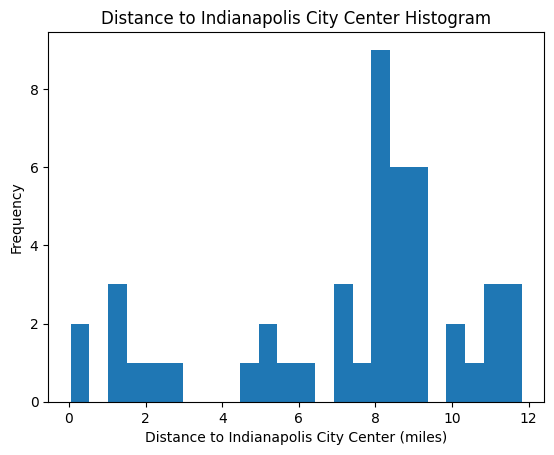

In [95]:
#Plotting the histogram of distances of fast food places from the city centre

n = complete_data.shape[0]
b = math.ceil(n ** 1/2)

plt.hist(complete_data['Distance_to_Indy_Center'], bins=b)
plt.xlabel('Distance to Indianapolis City Center (miles)')
plt.ylabel('Frequency')
plt.title('Distance to Indianapolis City Center Histogram')
plt.show()

#### We can see that most resturants are about 8-10 miles from the city centre so most Xterns will need cars to get to fast food places but there are 6 places under 2 miles from the city centre so Xterns without cars can walk there

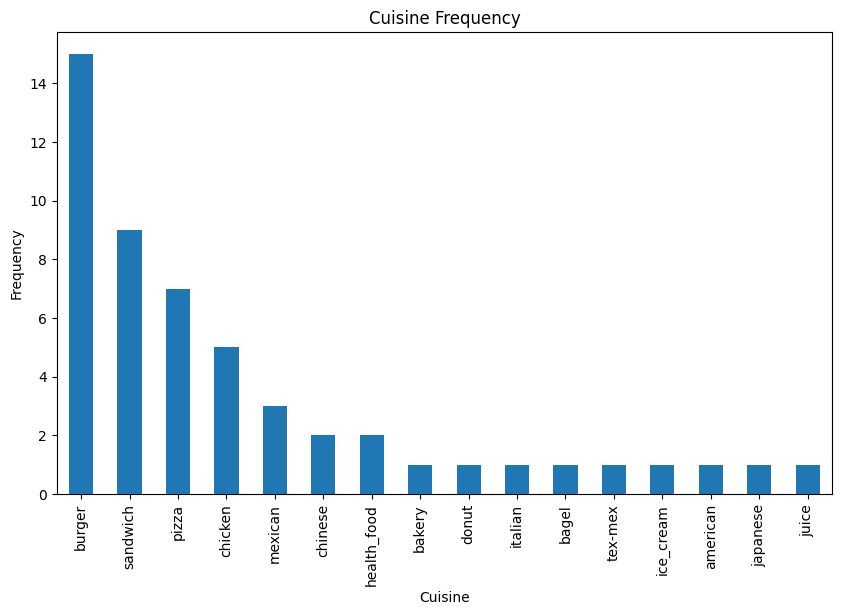

In [96]:
# We can now plot the number of restauratns for each cuisine

# We need to split the cuisnes and count them since they are ';' seperated in some cases
cuisines = complete_data['Cuisine'].str.split(';', expand=True).stack().reset_index(level=0, drop=True).reset_index(name='Cuisine')
counts = cuisines['Cuisine'].value_counts()
plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.title('Cuisine Frequency')
plt.xlabel('Cuisine')
plt.ylabel('Frequency')
plt.show()


#### We can notice that there a huge number of burger, sandwich and pizza places as compared to other places, we can also see that the total number of resturants from adding the frequency is higher than the total number of restaurants. This is because some restaurants had more than 1 cuisine associated with them

In [97]:
#Now we find the number of restaurants open on saturdays and sundays for the weekend plan
saturday = complete_data[complete_data['Hours'].str.contains('Sa', case=False, na=False) | complete_data['Hours'].str.contains('Mo-Su', case=False, na=False) | complete_data['Hours'].str.contains('Fr-Su', case=False, na=False) ]
sunday = complete_data[complete_data['Hours'].str.contains('Su', case=False, na=False) | complete_data['Hours'].str.contains('Mo-Su', case=False, na=False)]

saturday.head()
sunday

,Name,Address,Rating,Website,Hours,Cuisine,Latitude,Longitude,Address_missing,Rating_missing,Website_missing,Hours_missing,Cuisine_missing,Latitude_missing,Longitude_missing,Distance_to_Indy_Center
12,Chipotle,East 96th Street,NaN,https://www.chipotle.com/,Mo-Su 11:00-22:00,mexican,39.926426,-86.090320,0,1,0,0,0,0,0,11.486560
14,Jersey Mike's Subs,E. 82nd Street,NaN,https://www.jerseymikes.com,Mo-Sa 10:00-21:00; Su 11:00-19:00,sandwich,39.904289,-86.083958,0,1,0,0,0,0,0,10.174164
29,Domino's,East 21st Street,NaN,NaN,Mo-Su 10:00-24:00,pizza,39.796596,-85.991164,0,1,1,0,0,0,0,9.095017
33,Penn Station,East 82nd Street,NaN,NaN,Mo-Su 10:30-21:00,sandwich,39.904353,-86.052911,0,1,1,0,0,0,0,10.924248


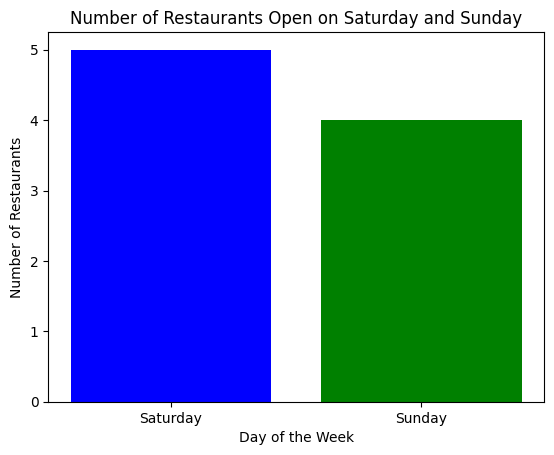

In [98]:
# create a graph of the number of restaurants open over the weekend
count_saturday = saturday.shape[0]
count_sunday = sunday.shape[0]

# Create a bar chart
days = ['Saturday', 'Sunday']
counts = [count_saturday, count_sunday]

plt.bar(days, counts, color=['blue', 'green'])
plt.xlabel('Day of the Week')
plt.ylabel('Number of Restaurants')
plt.title('Number of Restaurants Open on Saturday and Sunday')
plt.show()

#### So we can see that very few fast food places are open on the weekend with only 5 open on saturday and 4 on sunday, which doesn't give our Xterns a lot of flexibility with choices

## Weekend Plan

In [99]:
# We find 3 fast food places closest to the city centre to visit on saturday
sat_trav = saturday.nsmallest(3, 'Distance_to_Indy_Center')

print(sat_trav)

#we remove the sat_trav fast food places from the sunday dataset so we don't repeat places
remove = sunday[sunday.isin(sat_trav.to_dict(orient='list')).all(axis=1)].index

new_sunday = sunday.drop(remove)

print(new_sunday.shape[0])

sun_trav = pd.concat([new_sunday.nsmallest(3, 'Distance_to_Indy_Center'), saturday.nsmallest(2, 'Distance_to_Indy_Center')], ignore_index=True)

print(sun_trav["Name"])



                  Name           Address  Rating                      Website  \
29            Domino's  East 21st Street     NaN                          NaN   
14  Jersey Mike's Subs    E. 82nd Street     NaN  https://www.jerseymikes.com   
33        Penn Station  East 82nd Street     NaN                          NaN   

                                Hours   Cuisine   Latitude  Longitude  \
29                  Mo-Su 10:00-24:00     pizza  39.796596 -85.991164   
14  Mo-Sa 10:00-21:00; Su 11:00-19:00  sandwich  39.904289 -86.083958   
33                  Mo-Su 10:30-21:00  sandwich  39.904353 -86.052911   

    Address_missing  Rating_missing  Website_missing  Hours_missing  \
29                0               1                1              0   
14                0               1                0              0   
33                0               1                1              0   

    Cuisine_missing  Latitude_missing  Longitude_missing  \
29                0                 0

#### In the above cell, we create the plan for saturday and then remove those fast food places from the sunday dataframe since we don't want the Xterns to repeat places and try out newer places. But we discover that there is only 1 fast food place left in the sunday dataframe

#### So, we take the 2 places from the saturday dataframe that are closest to the city centre for convenience and add them to the sunday travel plan

In [100]:
#We create map centred at the Indianapolis city centre
indy_map = folium.Map(location=[39.7684, -86.158], zoom_start=11)

current_location = (39.7684, -86.158)

#we initialize our plans
day1_plan =[]
day2_plan=[]

# This counter is used to calculate what time we go to the places on both days
c = 0


#function to add place to plan
def add_to_plan(plan, restaurant):
    if c == 0:
        time = '1100'
    elif c == 1:
        time = '1400'
    else:
        time = '2000'
    restaurant_location = (restaurant["Latitude"], restaurant["Longitude"])
    distance = calculate_distance(current_location, restaurant_location)
    travel_distance = round(distance, 2)
    transportation_type = 'Car' if travel_distance > 0.5 else 'Walk'

    plan.append({
        'time': time,
        'location_name': restaurant['Name'],
        'address': restaurant['Address'],
        'cuisine': restaurant['Cuisine'],
        'travel_distance': f'{travel_distance} miles',
        'transportation_type': transportation_type,
        'Latitude': restaurant["Latitude"],
        'Longitude': restaurant['Longitude']
    })

    return restaurant_location

#function to add a marker to the map
def add_marker_to_map(map, location, name, color):
    folium.Marker(
        location=location,
        popup=name,
        icon=folium.Icon(color=color)
    ).add_to(map)

#function to add travel route to map
def visualize_route(map, plan, col, col2):
 
    route = [current_location]
    #print(route)
    add_marker_to_map(indy_map, current_location, "start", "red")
    folium.PolyLine(route, color=col, weight=2.5, opacity=1).add_to(map)
    for restaurant in plan:
        location = (restaurant["Latitude"], restaurant["Longitude"])
        route.append(location)
        add_marker_to_map(indy_map, location, restaurant['location_name'], col2)
        folium.PolyLine(route, color=col, weight=2.5, opacity=1).add_to(map)
    
    #print(len(route))




In [101]:
# DAY 1 PLAN

for index, restaurant in sat_trav.iterrows():
    #print("ddahkd")
    #print(restaurant["Latitude"])
    current_location = add_to_plan(day1_plan, restaurant)
    c += 1

visualize_route(indy_map, day1_plan, "blue", "green")

In [102]:
# DAY 2 PLAN

c = 0
for index, restaurant in sun_trav.iterrows():
    #print("ddahkd")
    #print(restaurant["Latitude"])
    current_location = add_to_plan(day2_plan, restaurant)
    c += 1

visualize_route(indy_map, day2_plan, "red", "purple")


In [103]:
#add day 1 and day 2 subheadings and make a csv

day1_plan = [{
        'time': 'NA',
        'location_name': 'Day 1',
        'address':'NA' ,
        'cuisine': 'NA',
        'travel_distance': 'NA',
        'transportation_type': 'NA',
        'Latitude': 'NA',
        'Longitude': 'NA'
    }] + day1_plan

day2_plan = [{
        'time': 'NA',
        'location_name': 'Day 2',
        'address':'NA' ,
        'cuisine': 'NA',
        'travel_distance': 'NA',
        'transportation_type': 'NA',
        'Latitude': 'NA',
        'Longitude': 'NA'
    }] + day2_plan

csv_file = "plan.csv"

with open(csv_file, "w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=day1_plan[0].keys())
    writer.writeheader()
    writer.writerows(day1_plan)
    writer.writerows(day2_plan)

In [104]:
indy_map

### From this map and the data, we can see that most fast food places open on the weekends are far away from the city centre which require a car to reach there. 

### Potential ways to find better results is to look for better data maybe using Google Maps API which may contain more places closer to the city centre adn also their ratings.

### Using the same code on more data will yield better results closer to the cuty centre that the Xterns can even walk to

### Thank you for going through this work sample assessment, hope to hear back from you soon
### - Yash Ashtekar